In [1]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load and process the data

In [3]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
y = pd.Series(data=df['Passengers'].values, index=df['Month'])
y.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

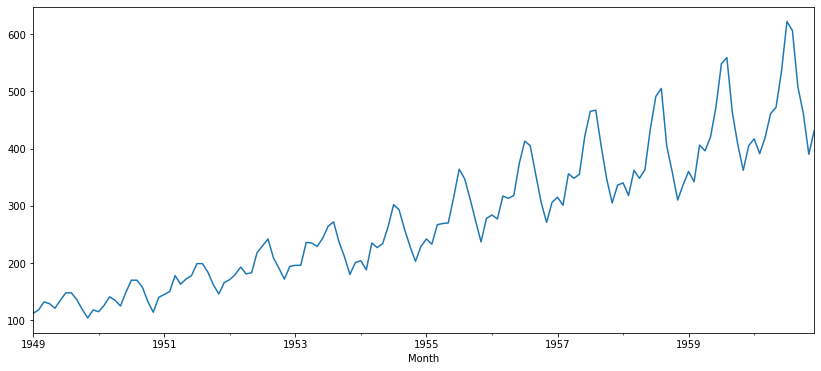

In [5]:
y.plot(figsize=(14, 6))
plt.show()

In [6]:
data = y.values.reshape(y.size,1)

# LSTM Forecast Model

### LSTM Data Preparation

In [7]:
'MixMaxScaler'
scaler = MinMaxScaler(feature_range=(0, 1))
data   = scaler.fit_transform(data)

In [8]:
train_size  = int(len(data) * 0.8)
test_size   = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('data train size :',train.shape[0])
print('data test size  :',test.shape[0])

data train size : 115
data test size  : 29


In [9]:
'function to reshape data according to the number of lags'

def reshape_data (data, look_back,time_steps):
    
    sub_seqs = int(look_back/time_steps)
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX,(dataX.shape[0],sub_seqs,time_steps,np.size(data,1)))
    return dataX, dataY

In [10]:
look_back = 2
time_steps = 1

trainX, trainY = reshape_data(train, look_back,time_steps)
testX, testY = reshape_data(test, look_back,time_steps)
print('train shape :',trainX.shape)
print('test shape  :',testX.shape)

train shape : (112, 2, 1, 1)
test shape  : (26, 2, 1, 1)


## Define and Fit  the Model

In [11]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, time_steps, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), verbose=0)

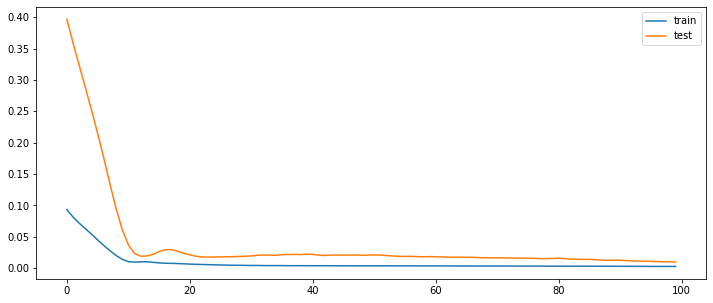

In [12]:
'plot history'
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test the performances

In [13]:
'make predictions'
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [14]:
'invert predictions'
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
'calculate root mean squared error' 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 27.20 RMSE
Test Score: 51.31 RMSE


In [16]:
'shift train predictions for plotting'
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

'shift test predictions for plotting'
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [17]:
'Make as pandas series to plot'
data_series = pd.Series(scaler.inverse_transform(data).ravel(), index=df['Month'])
trainPredict_series = pd.Series(trainPredictPlot.ravel(), index=df['Month'])
testPredict_series  = pd.Series(testPredictPlot.ravel(), index=df['Month'])

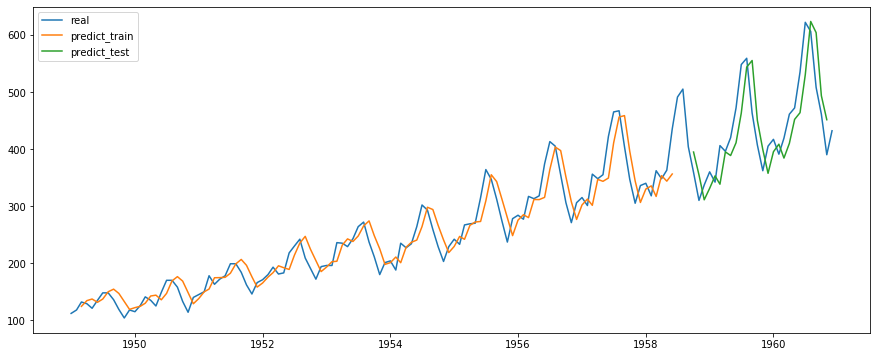

In [18]:
'plot baseline and predictions'
plt.figure(figsize=(15,6))
plt.plot(data_series,label = 'real')
plt.plot(trainPredict_series,label = 'predict_train')
plt.plot(testPredict_series,label = 'predict_test')
plt.legend()
plt.show()

In [19]:
'Predict all the data'
dataX, dataY = reshape_data(data, look_back,time_steps)
dataPredict = model.predict(dataX)

dataPredict = scaler.inverse_transform(dataPredict)
dataY = scaler.inverse_transform([dataY])

dataPredictPlot = np.empty_like(data)
dataPredictPlot[:, :] = np.nan
dataPredictPlot[look_back:len(dataPredict)+look_back, :] = dataPredict

dataPredict_series = pd.Series(dataPredictPlot.ravel(), index=df['Month'])

## STL Decomposing 

In [20]:
predicted = dataPredict_series.dropna()

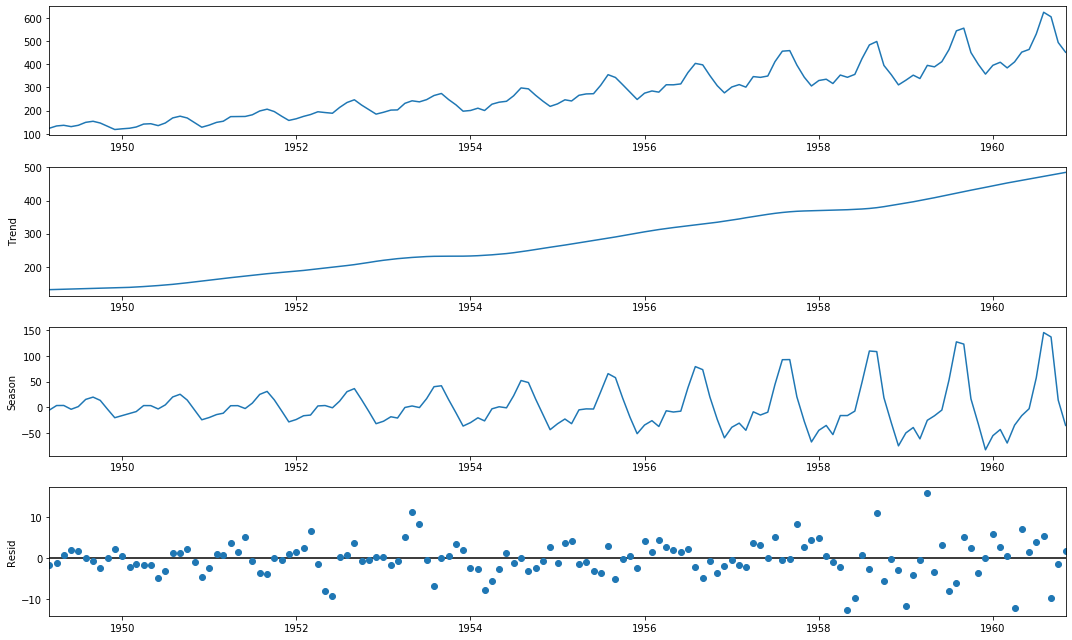

In [21]:
rcParams['figure.figsize'] = 15, 9
stl = STL(predicted).fit()
fig = stl.plot()
plt.show()

## Seasonal plot 

In [22]:
df_predicted = predicted.to_frame().reset_index()
df_predicted = df_predicted.rename(columns= {0: 'Passengers'})

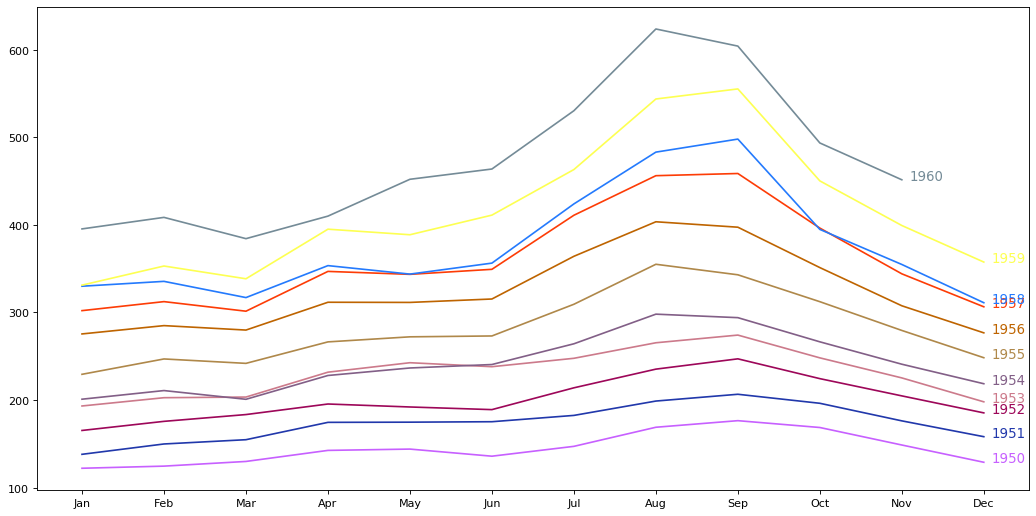

In [23]:
# Prepare data

df_predicted['year'] = [d.year for d in df_predicted.Month]
df_predicted['month'] = [d.strftime('%b') for d in df_predicted.Month]
years = df_predicted['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Passengers', data=df_predicted.loc[df_predicted.year==y, :], color=mycolors[i], label=y)
        plt.text(df_predicted.loc[df_predicted.year==y, :].shape[0]-.9,
                 df_predicted.loc[df_predicted.year==y, 'Passengers'][-1:].values[0],
                 y, fontsize=12, color=mycolors[i])

## Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

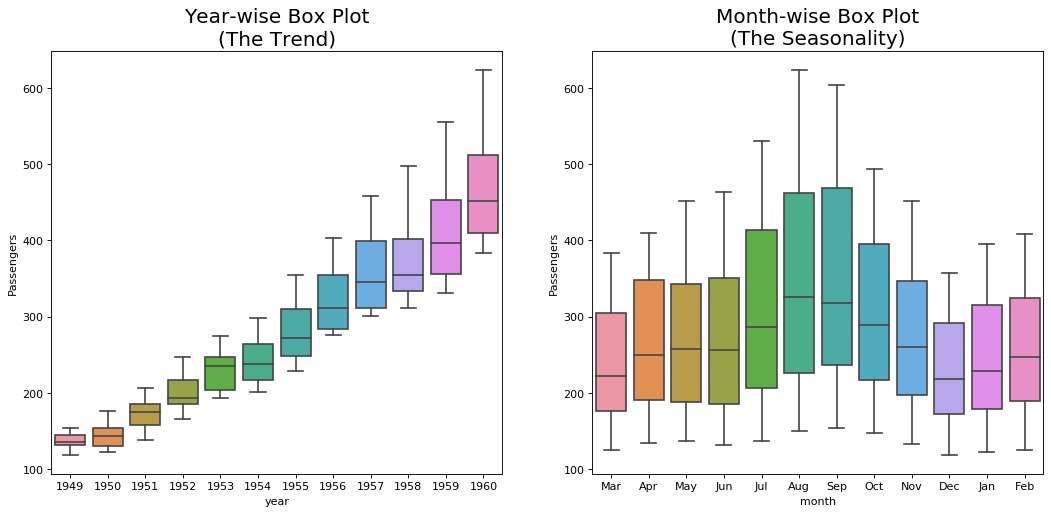

In [24]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7), dpi= 80)
sns.boxplot(x='year', y='Passengers', data=df_predicted, ax=axes[0])
sns.boxplot(x='month', y='Passengers', data=df_predicted.loc[~df_predicted.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# SARIMA Model

## 1. Grid search the p, d, q parameters

In [25]:
'Define the p, d and q parameters to take any value between 0 and 3'
p = d = q = range(0, 3)

'Generate all different combinations of p, q and q triplets'
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(predicted,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
            
        print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

        if results.aic < best_result[2]:
            best_result = [param, param_seasonal, results.aic]
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 1999.5374577050754
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 1705.7369379675717
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 1461.388642991022
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 1276.603382044967
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 1118.4090942723692
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 977.2867886385758
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 1058.787206893464
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 905.502204596879
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 792.5362753770839
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 1073.7501899309632
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 1062.5900204409709
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 971.5919578599926
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 1066.451983115414
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 993.9520895072754
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 868.5417971084285
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 936.0816896426151
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 903.5930895997665
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 794.51

ARIMA(0, 1, 2) x (1, 1, 0, 12) - AIC: 892.7005255076109
ARIMA(0, 1, 2) x (1, 1, 1, 12) - AIC: 873.5111413396185
ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 783.6354401633461
ARIMA(0, 1, 2) x (1, 2, 0, 12) - AIC: 820.5256662407935
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 784.2905879160946
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 694.4970160689883
ARIMA(0, 1, 2) x (2, 0, 0, 12) - AIC: 874.8697900466316
ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC: 876.8595177823963
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 855.6518634499323
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 807.1475354820916
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 809.1386272174485
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 784.3443046721314
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 730.7271782515023
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 719.6268007374832
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 696.3290615621304
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC: 1374.7866763268476
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC: 1179.6926900127387
ARIMA(0, 2, 0) x (0, 0, 2, 12) - AIC: 1036.830

ARIMA(1, 0, 1) x (2, 2, 0, 12) - AIC: 727.7123280149264
ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 717.0145322360478
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 709.8880850106119
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC: 1315.231571172642
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC: 1129.7627109620694
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 987.2611329820313
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC: 961.2353019094901
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 880.2223054429508
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC: 797.0569185491177
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC: 924.0557078129291
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 789.452413454797
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC: 698.3456112770631
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC: 955.8367448363022
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC: 939.3973213851879
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 861.347904157744
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 894.1077092329557
ARIMA(1, 0, 2) x (1, 1, 1, 12) - AIC: 880.4141874261927
ARIMA(1, 0, 2) x (1, 1, 2, 12) - AIC: 788.0168318

ARIMA(1, 2, 1) x (1, 0, 0, 12) - AIC: 955.765395694784
ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC: 945.0108216332604
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 866.277208288164
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC: 882.9079160080146
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 878.8389425051801
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 791.8933712228124
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 811.4904015587424
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 793.2054894173161
ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC: 700.1611136540682
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC: 870.0754638884371
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 871.6303798688001
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 865.2451973383935
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 798.8668686667822
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 800.6215700374471
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 793.8926462288179
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 719.6554957298252
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC: 709.6086594487938
ARIMA(1, 2, 1) x (2, 2, 2, 12) - AIC: 702.14141607

ARIMA(2, 1, 0) x (2, 1, 0, 12) - AIC: 793.710258652113
ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 795.6062430059012
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 792.7300179892761
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 713.0672331834722
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 703.2651968196485
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 703.6501316278244
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC: 1300.1791120285125
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC: 1110.5290907673052
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 972.7218636026436
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC: 956.0762440777676
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC: 874.7020800626437
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 792.940408359868
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC: 934.5310455308804
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 793.1013386568939
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 699.2941933132088
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC: 950.7657354682343
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC: 944.2288095445385
ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC: 866.442417

## Train the model

In [30]:
mod = sm.tsa.statespace.SARIMAX(predicted,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 0, best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  141
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -474.273
Date:                             Sun, 17 May 2020   AIC                            954.547
Time:                                     15:21:43   BIC                            963.056
Sample:                                 03-01-1949   HQIC                           958.004
                                      - 11-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7689      0.084      9.173      0.000       0.605       0.933
ma.L1         -0.9734      

## Auto Sarima

In [28]:
import pmdarima as pm

smodel = pm.auto_arima(df_predicted.Passengers, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  141
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -479.208
Date:                             Sun, 17 May 2020   AIC                            966.417
Time:                                     15:17:56   BIC                            977.825
Sample:                                          0   HQIC                           971.052
                                             - 141                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0514      0.036      1.431      0.153      -0.019       0.122
ar.L1          0.7630      0.077      9.936      0.000       0.612       0.914
ma.L1         -0.9998      4.472     -0.224      0.823      -9.765       7.765
sigma2       102.2343    452.331      0.226      0.821    -784.319     988.787
===================================================================================
Ljung-Box (Q):                       49.89   Jarque-Bera (JB):                54.99
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               5.15   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plot model diagnostics

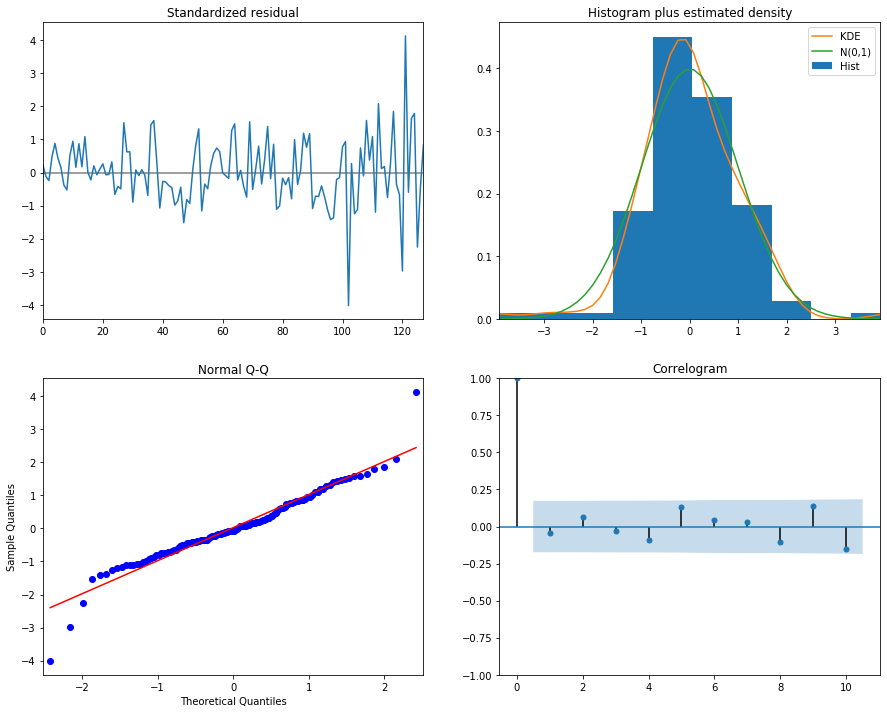

In [29]:
smodel.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
'make predictions'
pred = results.get_prediction(start=pd.to_datetime('1949-03-01'), dynamic=False,full_results=True)
pred_ci = pred.conf_int()

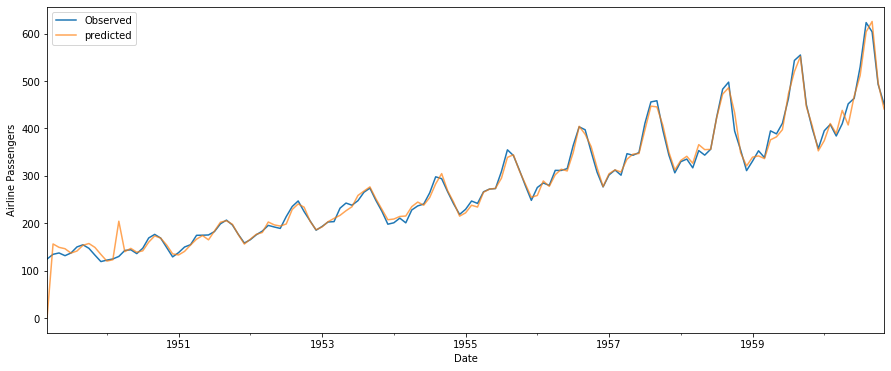

In [38]:
ax = predicted.plot(label='Observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [39]:
trainScore = math.sqrt(mean_squared_error(predicted, pred.predicted_mean))
print('Score: %.2f RMSE' % (trainScore))

Score: 16.00 RMSE


## Explain the params (p,d,q) S(P,D,Q)

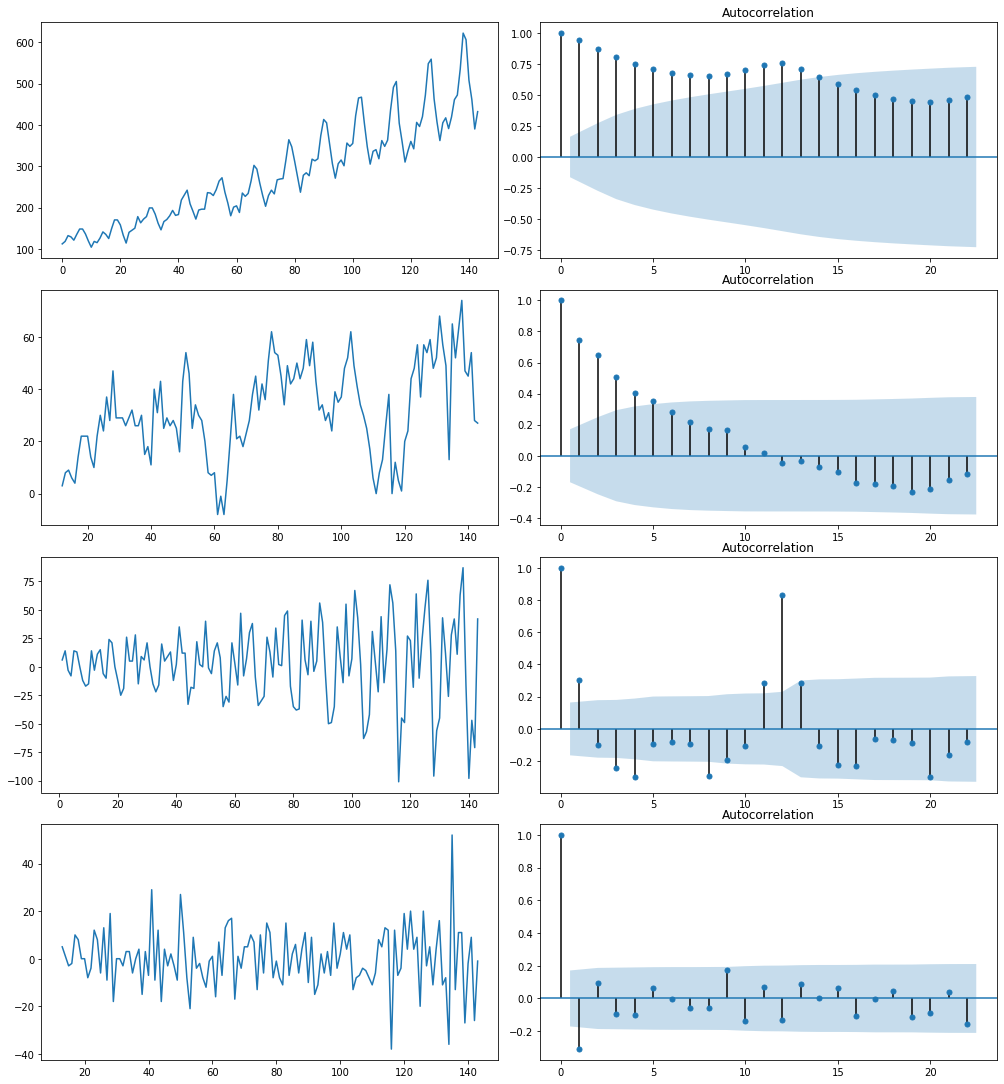

In [45]:
'parameters (D & d) : the orders of differencing'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(4, 2,figsize=(14,15))
fig.tight_layout()
axes[0, 0].plot(df.Passengers); axes[0, 0].set_title('')
plot_acf(df.Passengers, ax=axes[0, 1])

axes[1, 0].plot(df.Passengers.diff(12)); axes[1, 0].set_title('')
plot_acf(df.Passengers.diff(12).dropna(), ax=axes[1, 1])


axes[2, 0].plot(df.Passengers.diff()); axes[2, 0].set_title('')
plot_acf(df.Passengers.diff().dropna(), ax=axes[2, 1])

axes[3, 0].plot(df.Passengers.diff(12).diff()); axes[3, 0].set_title('')
plot_acf(df.Passengers.diff(12).diff().dropna(), ax=axes[3, 1])


plt.show()

In [41]:
'Adfuller test' 
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Passengers.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff(12).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff(12).diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

ADF Statistic: 0.815369
p-value: 0.991880
------------------------
ADF Statistic: -3.383021
p-value: 0.011551
------------------------
ADF Statistic: -2.829267
p-value: 0.054213
------------------------
ADF Statistic: -15.595618
p-value: 0.000000
------------------------


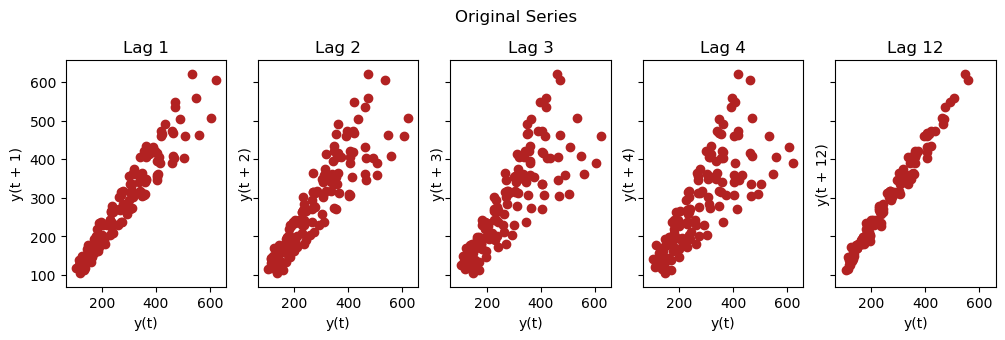

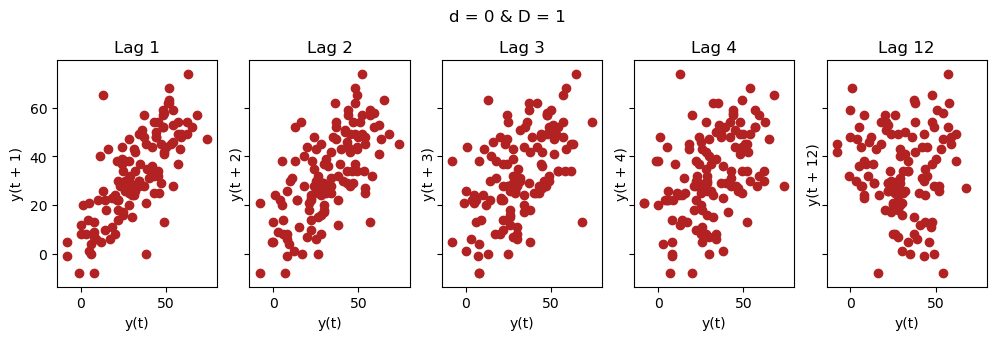

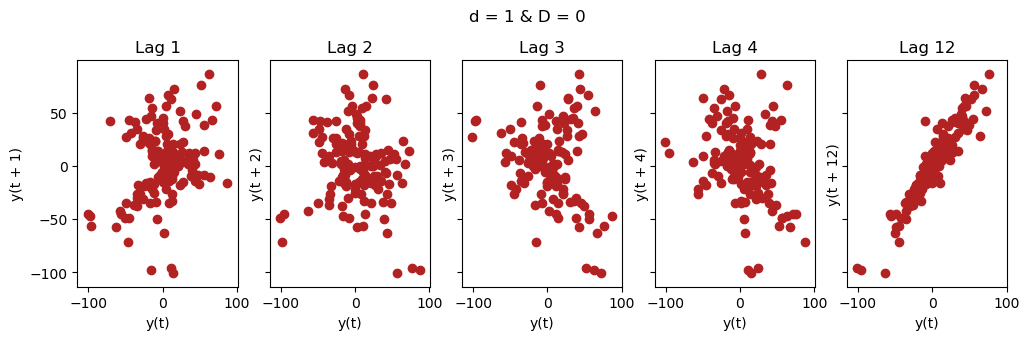

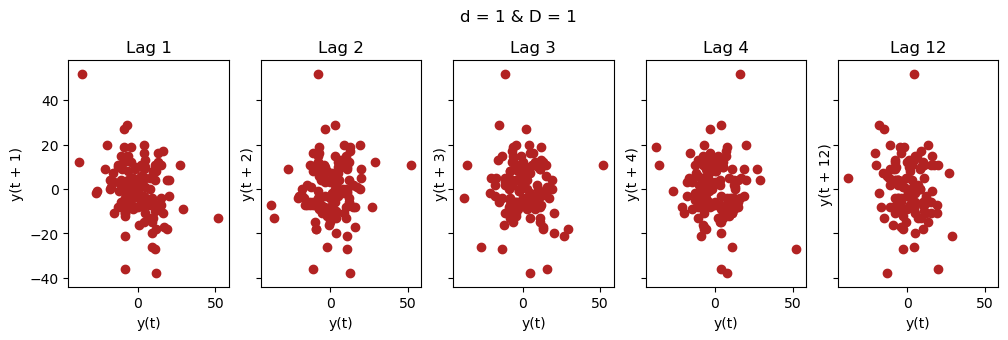

In [47]:
'Plot the lags'
from pandas.plotting import lag_plot

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 :
        lag_plot(df.Passengers, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers, lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('Original Series', y=1.05)

'-------------------------------------------------------------------------------------------'
    
fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff(12).dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff(12).dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('d = 0 & D = 1', y=1.05)

'-------------------------------------------------------------------------------------------'

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff().dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('d = 1 & D = 0', y=1.05)

'-------------------------------------------------------------------------------------------'

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff(12).diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff(12).diff().dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('d = 1 & D = 1', y=1.05)

plt.show()

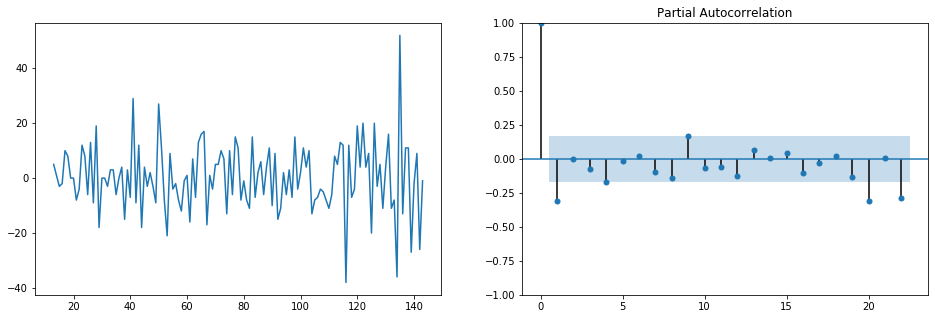

In [49]:
'parameters (P & p)  : orders of AR & SAR terms respectively '

fig, axes = plt.subplots(1, 2, figsize=(16,5), sharex=False)
axes[0].plot(df.Passengers.diff(12).diff()); axes[0].set_title('')
axes[1].set(ylim=(-1,1))
plot_pacf(df.Passengers.diff(12).diff().dropna(), ax=axes[1])

plt.show()

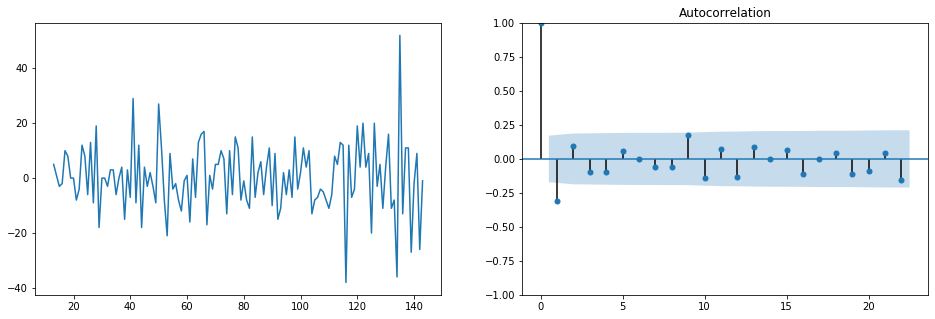

In [50]:
'parameters (Q & q)  : orders of MA & SMA terms respectively '


fig, axes = plt.subplots(1, 2, figsize=(16,5), sharex=False)
axes[0].plot(df.Passengers.diff(12).diff()); axes[0].set_title('')
axes[1].set(ylim=(-1,1))
plot_acf(df.Passengers.diff(12).diff().dropna(), ax=axes[1])

plt.show()